In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from classes import CustomLogisticRegression
from helpers import cv_evaluate_model

import warnings
warnings.filterwarnings('ignore')

# Set seaborn color palette
sns.set_palette("husl")

# Set random seed for reproducibility
seed = 777

In [4]:
import pickle

(train_X_folds, train_y_folds, test_X_folds, test_y_folds, feature_names_folds, reverse_map_folds, k_fold_split) = pickle.load(open('data/prepared_data_finetuning.pkl', 'rb'))

**NOTE**

To avoid fine-tuning the models on the same data used for evaluation, we used a separate 5-fold cross-validation set, generated with a different random seed, for fine-tuning. 

To make efficient use of computing resources, albeit at the expense of some precision, we adopt a multi-step fine-tuning strategy. We begin by optimizing the parameter dimension most likely to have a substantial impact on model performance while keeping other parameters fixed, then proceed sequentially to dimensions with lesser influence.

Fine-tuning was guided by two metrics: AUROC and AUROC overfitting, defined as the difference between training and testing AUROC values. AUROC was selected for its threshold-agnostic nature, allowing the thresholding decision to be deferred to downstream business use cases while assessing model discrimination across all possible cutoffs. Greater emphasis was placed on minimizing overfitting rather than solely maximizing AUROC, to ensure the generalizability of the resulting model.

### Logistic Regression: Fine-tuning Regularization Parameters

In [5]:
alpha_values = [0.0, 0.1, 1.0, 10.0, 100.0]

In [6]:
# L1 Regularization Evaluation (L1 ratio = 1.0)
print("🔍 Testing L1 Regularization (L1 ratio = 1.0)...")
print("=" * 60)

l1_results = {}

for alpha in alpha_values:
    print(f"Testing L1 α={alpha}...")
    
    # Evaluate with cross-validation
    results = cv_evaluate_model(
        lambda: CustomLogisticRegression(
            alpha=alpha,
            l1_ratio=1.0,  # Pure L1 regularization
            max_iter=1000,
            tol=1e-6,
            class_weight="balanced",
            random_state=seed
        ),
        train_X_folds,
        train_y_folds,
        test_X_folds,
        test_y_folds,
        get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
    )
    
    # Store results
    l1_results[alpha] = {
        'test_roc_auc': results['test_roc_auc'][0],
        'overfitting_auc': results['overfitting_auc'][0],
        'test_accuracy': results['test_accuracy'][0],
        'training_time': results['training_time'][0]
    }
    
    print(f"✅ L1 α={alpha}: Test AUC={results['test_roc_auc'][0]:.4f}, Overfitting AUC={results['overfitting_auc'][0]:.4f}")

print(f"\n✅ L1 testing completed! {len(l1_results)} configurations tested.")


🔍 Testing L1 Regularization (L1 ratio = 1.0)...
Testing L1 α=0.0...
Trained fold 0 in 17.27s
Trained fold 1 in 18.33s
Trained fold 2 in 19.74s
Trained fold 3 in 22.34s
Trained fold 4 in 21.79s
✅ L1 α=0.0: Test AUC=0.6730, Overfitting AUC=0.0195
Testing L1 α=0.1...
Trained fold 0 in 18.41s
Trained fold 1 in 13.18s
Trained fold 2 in 17.81s
Trained fold 3 in 18.03s
Trained fold 4 in 16.68s
✅ L1 α=0.1: Test AUC=0.6732, Overfitting AUC=0.0193
Testing L1 α=1.0...
Trained fold 0 in 11.35s
Trained fold 1 in 9.95s
Trained fold 2 in 9.84s
Trained fold 3 in 10.94s
Trained fold 4 in 10.82s
✅ L1 α=1.0: Test AUC=0.6741, Overfitting AUC=0.0182
Testing L1 α=10.0...
Trained fold 0 in 5.47s
Trained fold 1 in 6.38s
Trained fold 2 in 5.42s
Trained fold 3 in 5.70s
Trained fold 4 in 5.36s
✅ L1 α=10.0: Test AUC=0.6760, Overfitting AUC=0.0129
Testing L1 α=100.0...
Trained fold 0 in 19.88s
Trained fold 1 in 5.49s
Trained fold 2 in 13.71s
Trained fold 3 in 12.92s
Trained fold 4 in 10.72s
✅ L1 α=100.0: Test AUC=

In [7]:
# L2 Regularization Evaluation (L1 ratio = 0.0)
print("\n🔍 Testing L2 Regularization (L1 ratio = 0.0)...")
print("=" * 60)

l2_results = {}

for alpha in alpha_values:
    print(f"Testing L2 α={alpha}...")
    
    # Evaluate with cross-validation
    results = cv_evaluate_model(
        lambda: CustomLogisticRegression(
            alpha=alpha,
            l1_ratio=0.0,  # Pure L2 regularization
            max_iter=1000,
            tol=1e-6,
            class_weight="balanced",
            random_state=seed
        ),
        train_X_folds,
        train_y_folds,
        test_X_folds,
        test_y_folds,
        get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
    )
    
    # Store results
    l2_results[alpha] = {
        'test_roc_auc': results['test_roc_auc'][0],
        'overfitting_auc': results['overfitting_auc'][0],
        'test_accuracy': results['test_accuracy'][0],
        'training_time': results['training_time'][0]
    }
    
    print(f"✅ L2 α={alpha}: Test AUC={results['test_roc_auc'][0]:.4f}, Overfitting AUC={results['overfitting_auc'][0]:.4f}")

print(f"\n✅ L2 testing completed! {len(l2_results)} configurations tested.")



🔍 Testing L2 Regularization (L1 ratio = 0.0)...
Testing L2 α=0.0...
Trained fold 0 in 17.91s
Trained fold 1 in 19.20s
Trained fold 2 in 19.11s
Trained fold 3 in 20.62s
Trained fold 4 in 19.16s
✅ L2 α=0.0: Test AUC=0.6730, Overfitting AUC=0.0195
Testing L2 α=0.1...
Trained fold 0 in 10.56s
Trained fold 1 in 15.32s
Trained fold 2 in 18.94s
Trained fold 3 in 16.40s
Trained fold 4 in 16.73s
✅ L2 α=0.1: Test AUC=0.6732, Overfitting AUC=0.0193
Testing L2 α=1.0...
Trained fold 0 in 9.90s
Trained fold 1 in 7.17s
Trained fold 2 in 7.75s
Trained fold 3 in 8.42s
Trained fold 4 in 8.93s
✅ L2 α=1.0: Test AUC=0.6740, Overfitting AUC=0.0182
Testing L2 α=10.0...
Trained fold 0 in 5.29s
Trained fold 1 in 5.84s
Trained fold 2 in 4.40s
Trained fold 3 in 5.52s
Trained fold 4 in 5.12s
✅ L2 α=10.0: Test AUC=0.6754, Overfitting AUC=0.0155
Testing L2 α=100.0...
Trained fold 0 in 3.32s
Trained fold 1 in 2.77s
Trained fold 2 in 2.71s
Trained fold 3 in 2.54s
Trained fold 4 in 2.33s
✅ L2 α=100.0: Test AUC=0.6723


📊 Creating visualization plots...


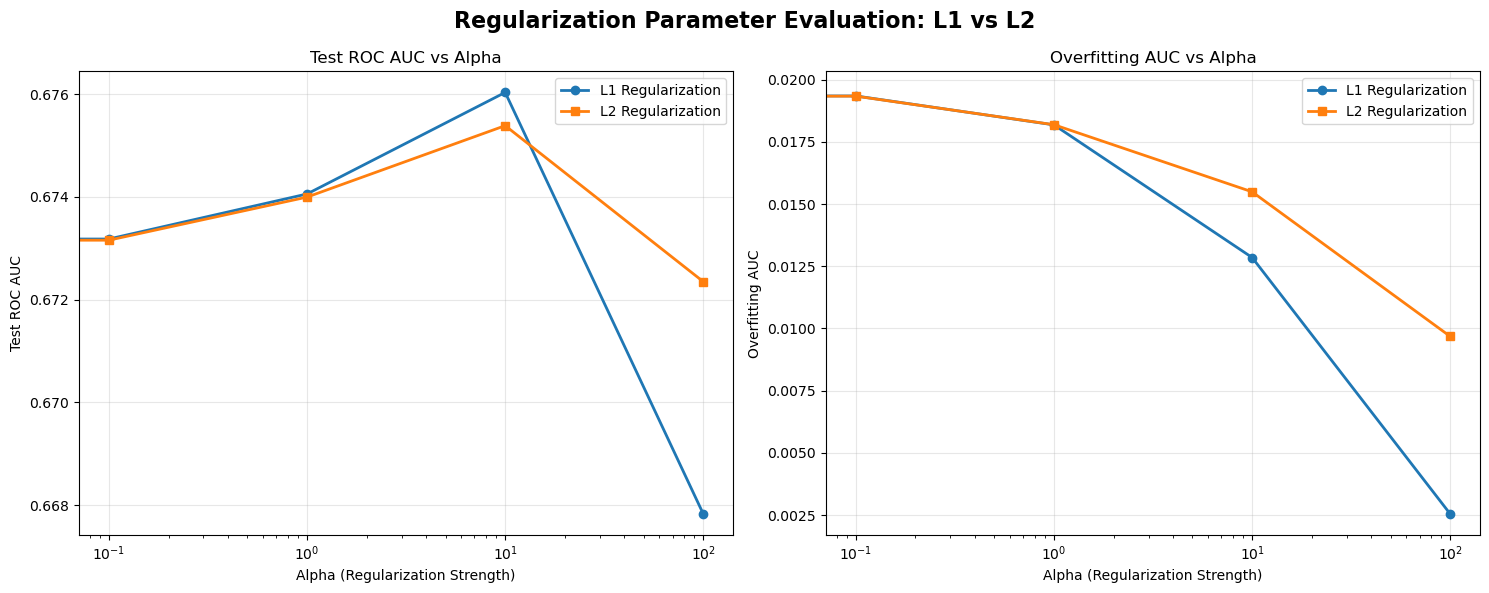

In [24]:
# Create visualization plots for L1 and L2 results
print("\n📊 Creating visualization plots...")
print("=" * 60)

# Prepare data for plotting
l1_alphas = list(l1_results.keys())
l1_aucs = [l1_results[alpha]['test_roc_auc'] for alpha in l1_alphas]
l1_overfitting = [l1_results[alpha]['overfitting_auc'] for alpha in l1_alphas]

l2_alphas = list(l2_results.keys())
l2_aucs = [l2_results[alpha]['test_roc_auc'] for alpha in l2_alphas]
l2_overfitting = [l2_results[alpha]['overfitting_auc'] for alpha in l2_alphas]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Regularization Parameter Evaluation: L1 vs L2', fontsize=16, fontweight='bold')

# Plot 1: ROC AUC vs Alpha
ax1 = axes[0]
ax1.plot(l1_alphas, l1_aucs, 'o-', label='L1 Regularization', linewidth=2, markersize=6)
ax1.plot(l2_alphas, l2_aucs, 's-', label='L2 Regularization', linewidth=2, markersize=6)
ax1.set_xlabel('Alpha (Regularization Strength)')
ax1.set_ylabel('Test ROC AUC')
ax1.set_title('Test ROC AUC vs Alpha')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Plot 2: Overfitting AUC vs Alpha
ax2 = axes[1]
ax2.plot(l1_alphas, l1_overfitting, 'o-', label='L1 Regularization', linewidth=2, markersize=6)
ax2.plot(l2_alphas, l2_overfitting, 's-', label='L2 Regularization', linewidth=2, markersize=6)
ax2.set_xlabel('Alpha (Regularization Strength)')
ax2.set_ylabel('Overfitting AUC')
ax2.set_title('Overfitting AUC vs Alpha')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate different L1-to-L2 ratios
print("\n🔍 Testing Mixed L1-L2 Regularization (Elastic Net)...")
print("=" * 60)

# Define L1 ratios to test (0.0 = pure L2, 1.0 = pure L1)
l1_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
# Use original alpha values for mixed evaluation
mixed_alpha_values = [5.0, 10.0, 20.0]

mixed_results = {}

for l1_ratio in l1_ratios:
    print(f"\nTesting L1 ratio = {l1_ratio}...")
    mixed_results[l1_ratio] = {}
    
    for alpha in mixed_alpha_values:
        print(f"  Testing α={alpha}...")
        
        # Evaluate with cross-validation
        results = cv_evaluate_model(
            lambda: CustomLogisticRegression(
                alpha=alpha,
                l1_ratio=l1_ratio,  # Mixed L1-L2 regularization
                max_iter=1000,
                tol=1e-6,
                class_weight="balanced",
                random_state=seed
            ),
            train_X_folds,
            train_y_folds,
            test_X_folds,
            test_y_folds,
            get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
        )
        
        # Store results
        mixed_results[l1_ratio][alpha] = {
            'test_roc_auc': results['test_roc_auc'][0],
            'overfitting_auc': results['overfitting_auc'][0],
            'test_accuracy': results['test_accuracy'][0],
            'training_time': results['training_time'][0]
        }
        
        print(f"    ✅ L1 ratio={l1_ratio}, α={alpha}: Test AUC={results['test_roc_auc'][0]:.4f}, Overfitting AUC={results['overfitting_auc'][0]:.4f}")

print(f"\n✅ Mixed L1-L2 testing completed!")



🔍 Testing Mixed L1-L2 Regularization (Elastic Net)...

Testing L1 ratio = 0.0...
  Testing α=5.0...
Trained fold 0 in 6.35s
Trained fold 1 in 6.39s
Trained fold 2 in 5.98s
Trained fold 3 in 5.41s
Trained fold 4 in 6.77s
    ✅ L1 ratio=0.0, α=5.0: Test AUC=0.6750, Overfitting AUC=0.0166
  Testing α=10.0...
Trained fold 0 in 4.80s
Trained fold 1 in 5.14s
Trained fold 2 in 3.89s
Trained fold 3 in 5.47s
Trained fold 4 in 4.90s
    ✅ L1 ratio=0.0, α=10.0: Test AUC=0.6754, Overfitting AUC=0.0155
  Testing α=20.0...
Trained fold 0 in 4.04s
Trained fold 1 in 3.72s
Trained fold 2 in 3.83s
Trained fold 3 in 3.73s
Trained fold 4 in 3.90s
    ✅ L1 ratio=0.0, α=20.0: Test AUC=0.6755, Overfitting AUC=0.0140

Testing L1 ratio = 0.25...
  Testing α=5.0...
Trained fold 0 in 6.03s
Trained fold 1 in 5.81s
Trained fold 2 in 5.23s
Trained fold 3 in 6.24s
Trained fold 4 in 6.74s
    ✅ L1 ratio=0.25, α=5.0: Test AUC=0.6752, Overfitting AUC=0.0163
  Testing α=10.0...
Trained fold 0 in 5.25s
Trained fold 1 in


📊 Creating heatmap visualization for mixed L1-L2 results...


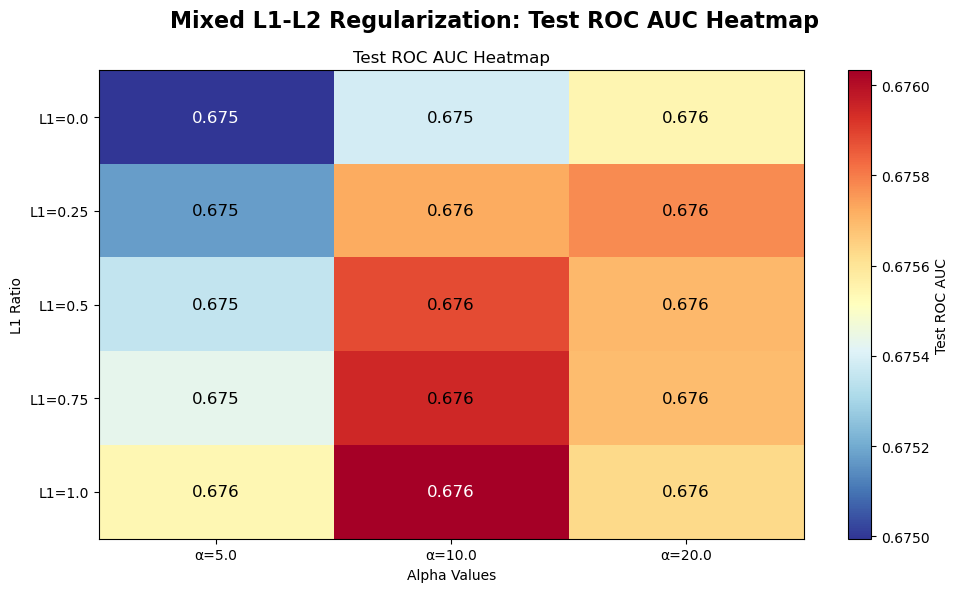


🏆 BEST MIXED CONFIGURATION:
   L1 Ratio: 1.0
   Alpha: 10.0
   Test ROC AUC: 0.6760
   Overfitting AUC: 0.0129

📊 MIXED L1-L2 SUMMARY:
   Best Test AUC: 0.6760
   Worst Test AUC: 0.6750
   Mean Test AUC: 0.6756
   Std Test AUC: 0.0003


In [52]:
# Create heatmap visualization for mixed L1-L2 results
print("\n📊 Creating heatmap visualization for mixed L1-L2 results...")
print("=" * 60)

# Prepare data for heatmap
heatmap_auc = np.zeros((len(l1_ratios), len(mixed_alpha_values)))
heatmap_overfitting = np.zeros((len(l1_ratios), len(mixed_alpha_values)))

for i, l1_ratio in enumerate(l1_ratios):
    for j, alpha in enumerate(mixed_alpha_values):
        heatmap_auc[i, j] = mixed_results[l1_ratio][alpha]['test_roc_auc']
        heatmap_overfitting[i, j] = mixed_results[l1_ratio][alpha]['overfitting_auc']

# Create heatmap plot (ROC AUC only)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Mixed L1-L2 Regularization: Test ROC AUC Heatmap', fontsize=16, fontweight='bold')

# Plot: Test ROC AUC Heatmap
im = ax.imshow(heatmap_auc, cmap='RdYlBu_r', aspect='auto')
ax.set_xticks(range(len(mixed_alpha_values)))
ax.set_yticks(range(len(l1_ratios)))
ax.set_xticklabels([f'α={a}' for a in mixed_alpha_values])
ax.set_yticklabels([f'L1={r}' for r in l1_ratios])
ax.set_xlabel('Alpha Values')
ax.set_ylabel('L1 Ratio')
ax.set_title('Test ROC AUC Heatmap')

# Add text annotations with conditional color
max_val = np.max(heatmap_auc)
min_val = np.min(heatmap_auc)
for i in range(len(l1_ratios)):
    for j in range(len(mixed_alpha_values)):
        val = heatmap_auc[i, j]
        # Use white text for highest and lowest values, black for others
        text_color = "white" if (val == max_val or val == min_val) else "black"
        text = ax.text(j, i, f'{val:.3f}', 
                      ha="center", va="center", color=text_color, size=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Test ROC AUC')

plt.tight_layout()
plt.show()

# Find best mixed configuration
best_idx = np.unravel_index(np.argmax(heatmap_auc), heatmap_auc.shape)
best_l1_ratio = l1_ratios[best_idx[0]]
best_alpha = mixed_alpha_values[best_idx[1]]
best_auc = heatmap_auc[best_idx]
best_overfitting = heatmap_overfitting[best_idx]

print(f"\n🏆 BEST MIXED CONFIGURATION:")
print(f"   L1 Ratio: {best_l1_ratio}")
print(f"   Alpha: {best_alpha}")
print(f"   Test ROC AUC: {best_auc:.4f}")
print(f"   Overfitting AUC: {best_overfitting:.4f}")

# Summary statistics
print(f"\n📊 MIXED L1-L2 SUMMARY:")
print(f"   Best Test AUC: {np.max(heatmap_auc):.4f}")
print(f"   Worst Test AUC: {np.min(heatmap_auc):.4f}")
print(f"   Mean Test AUC: {np.mean(heatmap_auc):.4f}")
print(f"   Std Test AUC: {np.std(heatmap_auc):.4f}")


**NOTE**

For logistic regression, we optimized L1 and L2 regularization terms independently to understand how each affects model performance. In our dataset, this relationship was well-behaved - greater regularization reduced overfitting, and a clear sweet spot emerged where AUROC was maximized without requiring a trade-off. After identifying the optimal alpha value around 10.0, we conducted a narrower grid search centered on this value, varying the L1-to-L2 ratio.

### Kernel SVM: Fine-tuning RFF gamma value

In [ ]:
# Kernel SVM (RFF) Fine-tuning - Step 1: Optimize Gamma Parameter
print("\n🔍 Step 1: Testing Kernel SVM (RFF) with different gamma values...")
print("=" * 60)

# Define gamma values to test
gamma_values = [0.001, 0.01, 0.1, 1.0]
n_components_fixed = 3000  # Fixed n_components for gamma optimization

gamma_results = {}

for gamma in gamma_values:
    print(f"Testing RFF γ={gamma} (n_components={n_components_fixed})...")
    
    # Evaluate with cross-validation
    results = cv_evaluate_model(
        lambda: Pipeline([
            ('rff', RBFSampler(gamma=gamma, n_components=n_components_fixed, random_state=seed)),
            ('sgd', SGDClassifier(
                loss='hinge',
                max_iter=1000,
                random_state=seed,
                class_weight='balanced',
                learning_rate='optimal'
            ))
        ]),
        train_X_folds,
        train_y_folds,
        test_X_folds,
        test_y_folds,
        get_decision_score=lambda model, X: model.decision_function(X)
    )
    
    # Store results
    gamma_results[gamma] = {
        'test_roc_auc': results['test_roc_auc'][0],
        'overfitting_auc': results['overfitting_auc'][0],
        'test_accuracy': results['test_accuracy'][0],
        'training_time': results['training_time'][0]
    }
    
    print(f"✅ RFF γ={gamma}: Test AUC={results['test_roc_auc'][0]:.4f}, Overfitting AUC={results['overfitting_auc'][0]:.4f}")

print(f"\n✅ Gamma optimization completed! {len(gamma_results)} configurations tested.")



🔍 Step 1: Testing Kernel SVM (RFF) with different gamma values...
Testing RFF γ=0.001 (n_components=3000)...
Trained fold 0 in 26.87s
Trained fold 1 in 41.18s
Trained fold 2 in 28.94s
Trained fold 3 in 30.11s
Trained fold 4 in 24.69s
✅ RFF γ=0.001: Test AUC=0.6517, Overfitting AUC=0.0034
Testing RFF γ=0.01 (n_components=3000)...
Trained fold 0 in 25.91s
Trained fold 1 in 21.22s
Trained fold 2 in 18.83s
Trained fold 3 in 25.99s
Trained fold 4 in 23.82s
✅ RFF γ=0.01: Test AUC=0.6654, Overfitting AUC=0.0108
Testing RFF γ=0.1 (n_components=3000)...
Trained fold 0 in 15.88s
Trained fold 1 in 19.46s
Trained fold 2 in 19.50s
Trained fold 3 in 16.67s
Trained fold 4 in 16.24s
✅ RFF γ=0.1: Test AUC=0.6511, Overfitting AUC=0.0640
Testing RFF γ=1.0 (n_components=3000)...
Trained fold 0 in 12.30s
Trained fold 1 in 12.83s
Trained fold 2 in 16.66s
Trained fold 3 in 16.81s
Trained fold 4 in 15.28s
✅ RFF γ=1.0: Test AUC=0.4948, Overfitting AUC=0.1782

✅ Gamma optimization completed! 4 configurations t


📊 Creating Step 1 visualization plots...


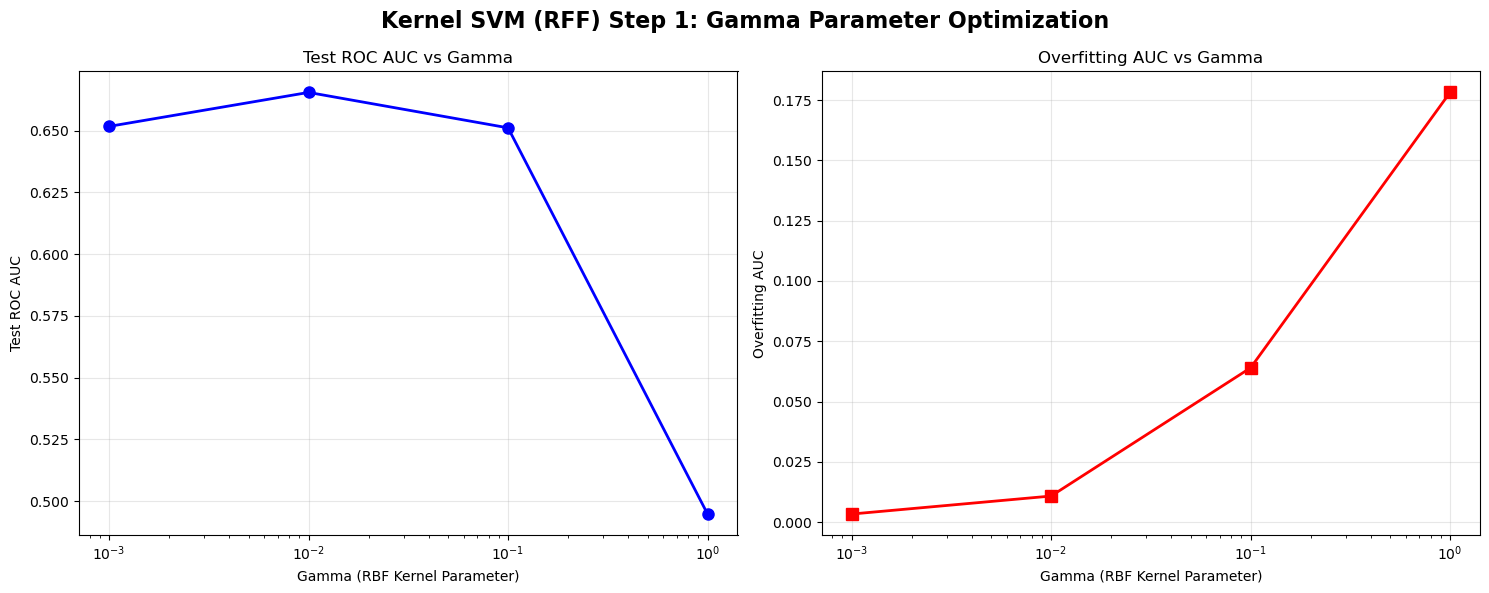


🏆 BEST GAMMA CONFIGURATION (Step 1):
Best Gamma: 0.01
Test ROC AUC: 0.6654
Overfitting AUC: 0.0108

📊 GAMMA OPTIMIZATION SUMMARY:
   Best Test AUC: 0.6654
   Worst Test AUC: 0.4948
   Mean Test AUC: 0.6158
   Std Test AUC: 0.0701


In [21]:
# Create visualization plots for Step 1 (Gamma optimization)
print("\n📊 Creating Step 1 visualization plots...")
print("=" * 60)

# Prepare data for plotting
gamma_vals = list(gamma_results.keys())
test_aucs = [gamma_results[gamma]['test_roc_auc'] for gamma in gamma_vals]
overfitting_aucs = [gamma_results[gamma]['overfitting_auc'] for gamma in gamma_vals]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Kernel SVM (RFF) Step 1: Gamma Parameter Optimization', fontsize=16, fontweight='bold')

# Plot 1: ROC AUC vs Gamma
ax1 = axes[0]
ax1.plot(gamma_vals, test_aucs, 'o-', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Gamma (RBF Kernel Parameter)')
ax1.set_ylabel('Test ROC AUC')
ax1.set_title('Test ROC AUC vs Gamma')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_ylim(auto=True)

# Plot 2: Overfitting AUC vs Gamma
ax2 = axes[1]
ax2.plot(gamma_vals, overfitting_aucs, 's-', linewidth=2, markersize=8, color='red')
ax2.set_xlabel('Gamma (RBF Kernel Parameter)')
ax2.set_ylabel('Overfitting AUC')
ax2.set_title('Overfitting AUC vs Gamma')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_ylim(auto=True)

plt.tight_layout()
plt.show()

# Find best gamma configuration
print("\n🏆 BEST GAMMA CONFIGURATION (Step 1):")
print("=" * 60)

best_gamma = max(gamma_results.keys(), key=lambda x: gamma_results[x]['test_roc_auc'])
best_auc = gamma_results[best_gamma]['test_roc_auc']
best_overfitting = gamma_results[best_gamma]['overfitting_auc']

print(f"Best Gamma: {best_gamma}")
print(f"Test ROC AUC: {best_auc:.4f}")
print(f"Overfitting AUC: {best_overfitting:.4f}")

# Summary statistics
print(f"\n📊 GAMMA OPTIMIZATION SUMMARY:")
print(f"   Best Test AUC: {max(test_aucs):.4f}")
print(f"   Worst Test AUC: {min(test_aucs):.4f}")
print(f"   Mean Test AUC: {np.mean(test_aucs):.4f}")
print(f"   Std Test AUC: {np.std(test_aucs):.4f}")


In [23]:
# Step 2: Optimize n_components with best gamma
print("\n🔍 Step 2: Testing Kernel SVM (RFF) with different n_components...")
print("=" * 60)

# Find best gamma from Step 1
best_gamma = max(gamma_results.keys(), key=lambda x: gamma_results[x]['test_roc_auc'])
print(f"Using best gamma from Step 1: γ={best_gamma}")

# Define n_components values to test
n_components_values = [1000, 2000, 3000]

n_components_results = {}

for n_components in n_components_values:
    print(f"Testing RFF n_components={n_components} (γ={best_gamma})...")
    
    # Evaluate with cross-validation
    results = cv_evaluate_model(
        lambda: Pipeline([
            ('rff', RBFSampler(gamma=best_gamma, n_components=n_components, random_state=seed)),
            ('sgd', SGDClassifier(
                loss='hinge',
                max_iter=1000,
                random_state=seed,
                class_weight='balanced',
                learning_rate='optimal'
            ))
        ]),
        train_X_folds,
        train_y_folds,
        test_X_folds,
        test_y_folds,
        get_decision_score=lambda model, X: model.decision_function(X)
    )
    
    # Store results
    n_components_results[n_components] = {
        'test_roc_auc': results['test_roc_auc'][0],
        'overfitting_auc': results['overfitting_auc'][0],
        'test_accuracy': results['test_accuracy'][0],
        'training_time': results['training_time'][0]
    }
    
    print(f"✅ RFF n_components={n_components}: Test AUC={results['test_roc_auc'][0]:.4f}, Overfitting AUC={results['overfitting_auc'][0]:.4f}")

print(f"\n✅ n_components optimization completed! {len(n_components_results)} configurations tested.")



🔍 Step 2: Testing Kernel SVM (RFF) with different n_components...
Using best gamma from Step 1: γ=0.01
Testing RFF n_components=1000 (γ=0.01)...
Trained fold 0 in 6.16s
Trained fold 1 in 6.54s
Trained fold 2 in 5.88s
Trained fold 3 in 6.99s
Trained fold 4 in 7.02s
✅ RFF n_components=1000: Test AUC=0.6641, Overfitting AUC=0.0100
Testing RFF n_components=2000 (γ=0.01)...
Trained fold 0 in 15.25s
Trained fold 1 in 23.81s
Trained fold 2 in 17.98s
Trained fold 3 in 15.54s
Trained fold 4 in 17.20s
✅ RFF n_components=2000: Test AUC=0.6657, Overfitting AUC=0.0101
Testing RFF n_components=3000 (γ=0.01)...
Trained fold 0 in 27.28s
Trained fold 1 in 23.59s
Trained fold 2 in 22.38s
Trained fold 3 in 26.96s
Trained fold 4 in 25.03s
✅ RFF n_components=3000: Test AUC=0.6654, Overfitting AUC=0.0108

✅ n_components optimization completed! 3 configurations tested.



📊 Creating Step 2 visualization plots...


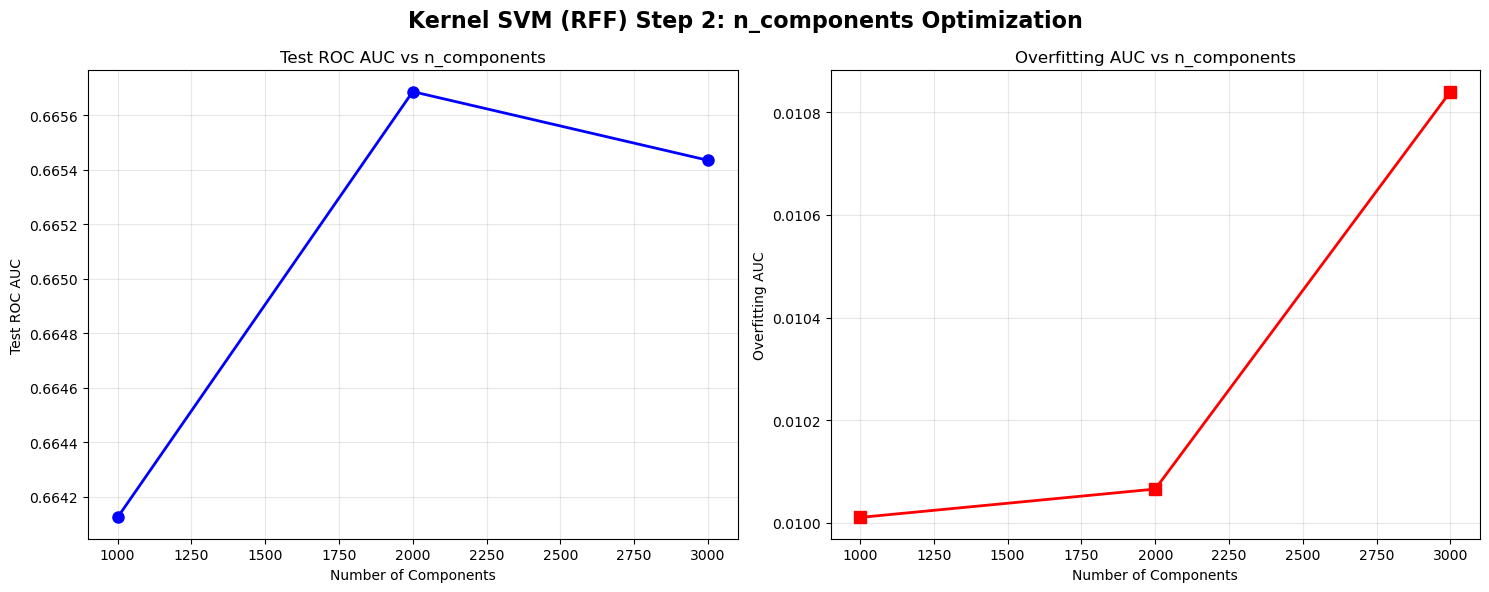


🏆 BEST n_components CONFIGURATION (Step 2):

🏆 OVERALL BEST KERNEL SVM CONFIGURATION:
   Best Gamma: 0.01
   Best n_components: 2000
   Test ROC AUC: 0.6657
   Overfitting AUC: 0.0101

📊 n_components OPTIMIZATION SUMMARY:
   Best Test AUC: 0.6657
   Worst Test AUC: 0.6641
   Mean Test AUC: 0.6651
   Std Test AUC: 0.0007


In [25]:
# Create visualization plots for Step 2 (n_components optimization)
print("\n📊 Creating Step 2 visualization plots...")
print("=" * 60)

# Prepare data for plotting
n_comp_vals = list(n_components_results.keys())
test_aucs = [n_components_results[n_comp]['test_roc_auc'] for n_comp in n_comp_vals]
overfitting_aucs = [n_components_results[n_comp]['overfitting_auc'] for n_comp in n_comp_vals]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Kernel SVM (RFF) Step 2: n_components Optimization', fontsize=16, fontweight='bold')

# Plot 1: ROC AUC vs n_components
ax1 = axes[0]
ax1.plot(n_comp_vals, test_aucs, 'o-', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Test ROC AUC')
ax1.set_title('Test ROC AUC vs n_components')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(auto=True)

# Plot 2: Overfitting AUC vs n_components
ax2 = axes[1]
ax2.plot(n_comp_vals, overfitting_aucs, 's-', linewidth=2, markersize=8, color='red')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Overfitting AUC')
ax2.set_title('Overfitting AUC vs n_components')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(auto=True)

plt.tight_layout()
plt.show()

# Find best n_components configuration
print("\n🏆 BEST n_components CONFIGURATION (Step 2):")
print("=" * 60)

best_n_components = max(n_components_results.keys(), key=lambda x: n_components_results[x]['test_roc_auc'])
best_auc = n_components_results[best_n_components]['test_roc_auc']
best_overfitting = n_components_results[best_n_components]['overfitting_auc']

# Overall best configuration
print(f"\n🏆 OVERALL BEST KERNEL SVM CONFIGURATION:")
print(f"   Best Gamma: {best_gamma}")
print(f"   Best n_components: {best_n_components}")
print(f"   Test ROC AUC: {best_auc:.4f}")
print(f"   Overfitting AUC: {best_overfitting:.4f}")

# Summary statistics
print(f"\n📊 n_components OPTIMIZATION SUMMARY:")
print(f"   Best Test AUC: {max(test_aucs):.4f}")
print(f"   Worst Test AUC: {min(test_aucs):.4f}")
print(f"   Mean Test AUC: {np.mean(test_aucs):.4f}")
print(f"   Std Test AUC: {np.std(test_aucs):.4f}")

**NOTE**

For the kernel SVM, we first optimized the gamma value, followed by the number of components, as gamma is known to have a more direct influence on overfitting. As with the logistic regression model, a clear sweet spot was observed where AUROC was maximized without an overfitting trade-off.

### Decision Tree: Fine-tuning tree depth and min samples in leaf

In [ ]:
# Decision Tree Fine-tuning - Step 1: Optimize max_depth
print("\n🔍 Step 1: Testing Decision Tree with different max_depth values...")
print("=" * 60)

# Define max_depth values to test
max_depth_values = [4, 5, 6, 7]
min_samples_leaf_fixed = 100  # Fixed min_samples_leaf for depth optimization
min_samples_split_fixed = min_samples_leaf_fixed * 2  # Always min_samples_leaf * 2

depth_results = {}

for max_depth in max_depth_values:
    print(f"Testing DT max_depth={max_depth} (min_samples_leaf={min_samples_leaf_fixed}, min_samples_split={min_samples_split_fixed})...")
    
    # Evaluate with cross-validation
    results = cv_evaluate_model(
        lambda: DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf_fixed,
            min_samples_split=min_samples_split_fixed,
            max_features=None,
            class_weight='balanced',
            random_state=seed
        ),
        train_X_folds,
        train_y_folds,
        test_X_folds,
        test_y_folds,
        get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
    )
    
    # Store results
    depth_results[max_depth] = {
        'test_roc_auc': results['test_roc_auc'][0],
        'overfitting_auc': results['overfitting_auc'][0],
        'test_accuracy': results['test_accuracy'][0],
        'training_time': results['training_time'][0]
    }
    
    print(f"✅ DT max_depth={max_depth}: Test AUC={results['test_roc_auc'][0]:.4f}, Overfitting AUC={results['overfitting_auc'][0]:.4f}")

print(f"\n✅ max_depth optimization completed! {len(depth_results)} configurations tested.")



🔍 Step 1: Testing Decision Tree with different max_depth values...
Testing DT max_depth=4 (min_samples_leaf=100, min_samples_split=200)...
Trained fold 0 in 6.50s
Trained fold 1 in 6.33s
Trained fold 2 in 6.17s
Trained fold 3 in 6.31s
Trained fold 4 in 6.22s
✅ DT max_depth=4: Test AUC=0.6416, Overfitting AUC=0.0031
Testing DT max_depth=5 (min_samples_leaf=100, min_samples_split=200)...
Trained fold 0 in 7.75s
Trained fold 1 in 7.87s
Trained fold 2 in 7.95s
Trained fold 3 in 7.79s
Trained fold 4 in 8.27s
✅ DT max_depth=5: Test AUC=0.6490, Overfitting AUC=0.0060
Testing DT max_depth=6 (min_samples_leaf=100, min_samples_split=200)...
Trained fold 0 in 9.44s
Trained fold 1 in 9.04s
Trained fold 2 in 8.72s
Trained fold 3 in 8.67s
Trained fold 4 in 9.06s
✅ DT max_depth=6: Test AUC=0.6482, Overfitting AUC=0.0139
Testing DT max_depth=7 (min_samples_leaf=100, min_samples_split=200)...
Trained fold 0 in 11.49s
Trained fold 1 in 10.98s
Trained fold 2 in 10.58s
Trained fold 3 in 11.10s
Trained fo


📊 Creating Step 1 visualization plots...


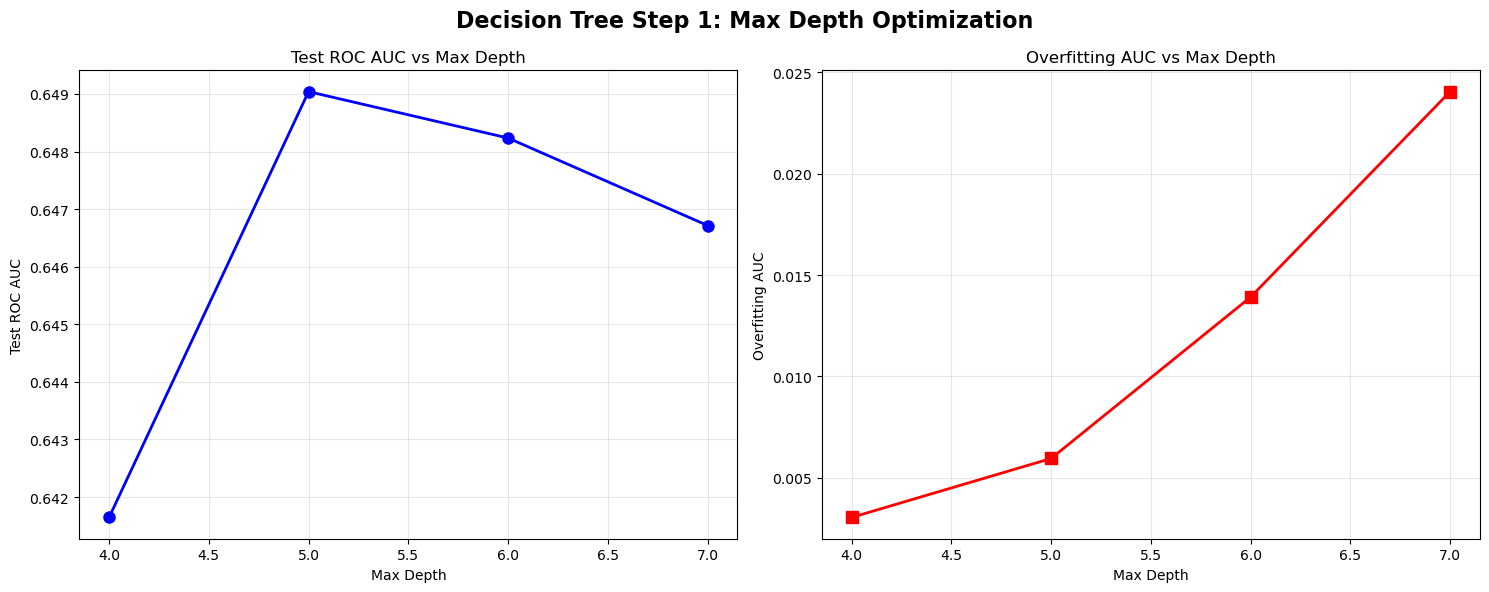


🏆 BEST MAX DEPTH CONFIGURATION (Step 1):
Best Max Depth: 5
Test ROC AUC: 0.6490
Overfitting AUC: 0.0060

📊 MAX DEPTH OPTIMIZATION SUMMARY:
   Best Test AUC: 0.6490
   Worst Test AUC: 0.6416
   Mean Test AUC: 0.6464
   Std Test AUC: 0.0029


In [30]:
# Create visualization plots for Step 1 (max_depth optimization)
print("\n📊 Creating Step 1 visualization plots...")
print("=" * 60)

# Prepare data for plotting
depth_vals = list(depth_results.keys())
depth_aucs = [depth_results[depth]['test_roc_auc'] for depth in depth_vals]
depth_overfitting = [depth_results[depth]['overfitting_auc'] for depth in depth_vals]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Decision Tree Step 1: Max Depth Optimization', fontsize=16, fontweight='bold')

# Plot 1: ROC AUC vs max_depth
ax1 = axes[0]
ax1.plot(depth_vals, depth_aucs, 'o-', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('Test ROC AUC')
ax1.set_title('Test ROC AUC vs Max Depth')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(auto=True)

# Plot 2: Overfitting AUC vs max_depth
ax2 = axes[1]
ax2.plot(depth_vals, depth_overfitting, 's-', linewidth=2, markersize=8, color='red')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Overfitting AUC')
ax2.set_title('Overfitting AUC vs Max Depth')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(auto=True)

plt.tight_layout()
plt.show()

# Find best max_depth configuration
print("\n🏆 BEST MAX DEPTH CONFIGURATION (Step 1):")
print("=" * 60)

best_depth = max(depth_results.keys(), key=lambda x: depth_results[x]['test_roc_auc'])
best_depth_auc = depth_results[best_depth]['test_roc_auc']
best_depth_overfitting = depth_results[best_depth]['overfitting_auc']

print(f"Best Max Depth: {best_depth}")
print(f"Test ROC AUC: {best_depth_auc:.4f}")
print(f"Overfitting AUC: {best_depth_overfitting:.4f}")

# Summary statistics
print(f"\n📊 MAX DEPTH OPTIMIZATION SUMMARY:")
print(f"   Best Test AUC: {max(depth_aucs):.4f}")
print(f"   Worst Test AUC: {min(depth_aucs):.4f}")
print(f"   Mean Test AUC: {np.mean(depth_aucs):.4f}")
print(f"   Std Test AUC: {np.std(depth_aucs):.4f}")


In [31]:
# Step 2: Optimize min_samples_leaf with best max_depth
print("\n🔍 Step 2: Testing Decision Tree with different min_samples_leaf values...")
print("=" * 60)

# Find best max_depth from Step 1
best_max_depth = max(depth_results.keys(), key=lambda x: depth_results[x]['test_roc_auc'])
print(f"Using best max_depth from Step 1: max_depth={best_max_depth}")

# Define min_samples_leaf values to test
min_samples_leaf_values = [20, 50, 100, 200]

leaf_results = {}

for min_samples_leaf in min_samples_leaf_values:
    min_samples_split = min_samples_leaf * 2  # Always min_samples_leaf * 2
    print(f"Testing DT min_samples_leaf={min_samples_leaf} (max_depth={best_max_depth}, min_samples_split={min_samples_split})...")
    
    # Evaluate with cross-validation
    results = cv_evaluate_model(
        lambda: DecisionTreeClassifier(
            max_depth=best_max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            max_features=None,
            class_weight='balanced',
            random_state=seed
        ),
        train_X_folds,
        train_y_folds,
        test_X_folds,
        test_y_folds,
        get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
    )
    
    # Store results
    leaf_results[min_samples_leaf] = {
        'test_roc_auc': results['test_roc_auc'][0],
        'overfitting_auc': results['overfitting_auc'][0],
        'test_accuracy': results['test_accuracy'][0],
        'training_time': results['training_time'][0]
    }
    
    print(f"✅ DT min_samples_leaf={min_samples_leaf}: Test AUC={results['test_roc_auc'][0]:.4f}, Overfitting AUC={results['overfitting_auc'][0]:.4f}")

print(f"\n✅ min_samples_leaf optimization completed! {len(leaf_results)} configurations tested.")



🔍 Step 2: Testing Decision Tree with different min_samples_leaf values...
Using best max_depth from Step 1: max_depth=5
Testing DT min_samples_leaf=20 (max_depth=5, min_samples_split=40)...
Trained fold 0 in 8.50s
Trained fold 1 in 8.09s
Trained fold 2 in 8.18s
Trained fold 3 in 8.29s
Trained fold 4 in 8.33s
✅ DT min_samples_leaf=20: Test AUC=0.6485, Overfitting AUC=0.0075
Testing DT min_samples_leaf=50 (max_depth=5, min_samples_split=100)...
Trained fold 0 in 8.21s
Trained fold 1 in 8.56s
Trained fold 2 in 9.08s
Trained fold 3 in 8.28s
Trained fold 4 in 8.12s
✅ DT min_samples_leaf=50: Test AUC=0.6485, Overfitting AUC=0.0072
Testing DT min_samples_leaf=100 (max_depth=5, min_samples_split=200)...
Trained fold 0 in 8.41s
Trained fold 1 in 8.28s
Trained fold 2 in 8.45s
Trained fold 3 in 8.46s
Trained fold 4 in 8.18s
✅ DT min_samples_leaf=100: Test AUC=0.6490, Overfitting AUC=0.0060
Testing DT min_samples_leaf=200 (max_depth=5, min_samples_split=400)...
Trained fold 0 in 7.90s
Trained fol


📊 Creating Step 2 visualization plots...


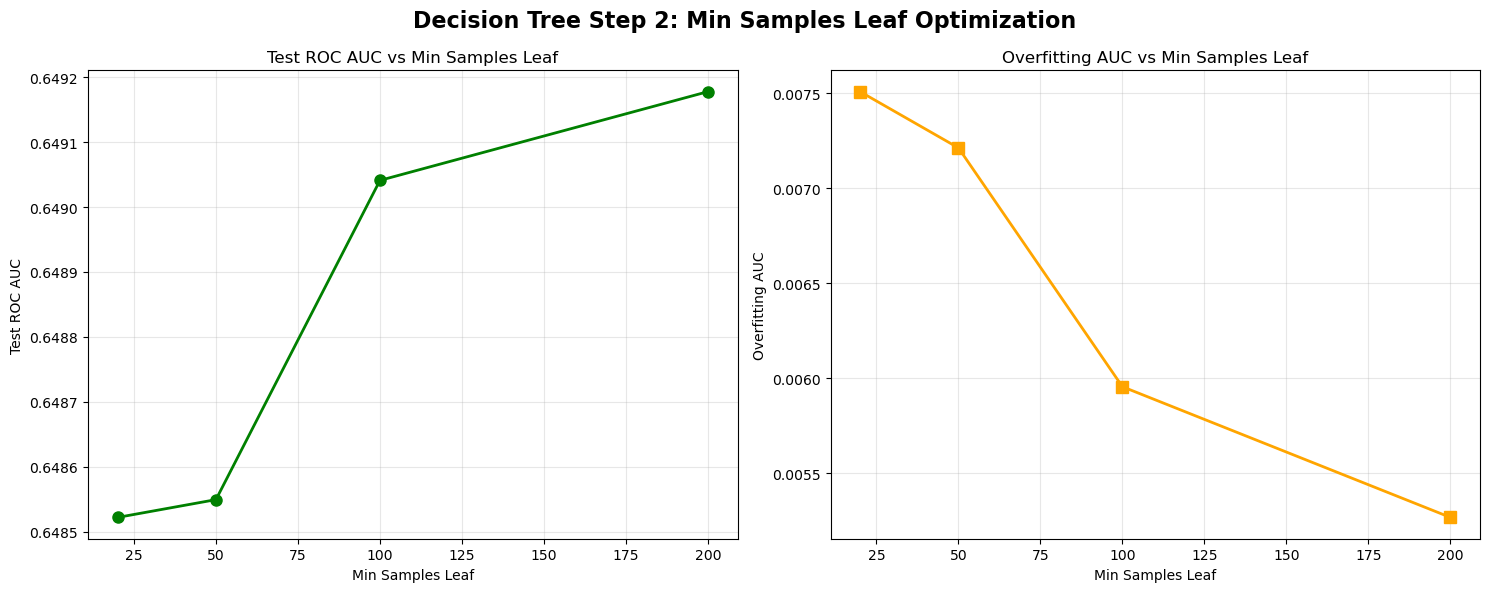


🏆 BEST MIN SAMPLES LEAF CONFIGURATION (Step 2):

🏆 OVERALL BEST DECISION TREE CONFIGURATION:
   Best Max Depth: 5
   Best Min Samples Leaf: 200
   Min Samples Split: 400
   Test ROC AUC: 0.6492
   Overfitting AUC: 0.0053

📊 MIN SAMPLES LEAF OPTIMIZATION SUMMARY:
   Best Test AUC: 0.6492
   Worst Test AUC: 0.6485
   Mean Test AUC: 0.6488
   Std Test AUC: 0.0003


In [33]:
# Create visualization plots for Step 2 (min_samples_leaf optimization)
print("\n📊 Creating Step 2 visualization plots...")
print("=" * 60)

# Prepare data for plotting
leaf_vals = list(leaf_results.keys())
leaf_aucs = [leaf_results[leaf]['test_roc_auc'] for leaf in leaf_vals]
leaf_overfitting = [leaf_results[leaf]['overfitting_auc'] for leaf in leaf_vals]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Decision Tree Step 2: Min Samples Leaf Optimization', fontsize=16, fontweight='bold')

# Plot 1: ROC AUC vs min_samples_leaf
ax1 = axes[0]
ax1.plot(leaf_vals, leaf_aucs, 'o-', linewidth=2, markersize=8, color='green')
ax1.set_xlabel('Min Samples Leaf')
ax1.set_ylabel('Test ROC AUC')
ax1.set_title('Test ROC AUC vs Min Samples Leaf')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(auto=True)

# Plot 2: Overfitting AUC vs min_samples_leaf
ax2 = axes[1]
ax2.plot(leaf_vals, leaf_overfitting, 's-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Min Samples Leaf')
ax2.set_ylabel('Overfitting AUC')
ax2.set_title('Overfitting AUC vs Min Samples Leaf')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(auto=True)

plt.tight_layout()
plt.show()

# Find best min_samples_leaf configuration
print("\n🏆 BEST MIN SAMPLES LEAF CONFIGURATION (Step 2):")
print("=" * 60)

best_leaf = max(leaf_results.keys(), key=lambda x: leaf_results[x]['test_roc_auc'])
best_leaf_auc = leaf_results[best_leaf]['test_roc_auc']
best_leaf_overfitting = leaf_results[best_leaf]['overfitting_auc']

# Overall best configuration
print(f"\n🏆 OVERALL BEST DECISION TREE CONFIGURATION:")
print(f"   Best Max Depth: {best_depth}")
print(f"   Best Min Samples Leaf: {best_leaf}")
print(f"   Min Samples Split: {best_leaf * 2}")
print(f"   Test ROC AUC: {best_leaf_auc:.4f}")
print(f"   Overfitting AUC: {best_leaf_overfitting:.4f}")

# Summary statistics
print(f"\n📊 MIN SAMPLES LEAF OPTIMIZATION SUMMARY:")
print(f"   Best Test AUC: {max(leaf_aucs):.4f}")
print(f"   Worst Test AUC: {min(leaf_aucs):.4f}")
print(f"   Mean Test AUC: {np.mean(leaf_aucs):.4f}")
print(f"   Std Test AUC: {np.std(leaf_aucs):.4f}")

**NOTE**

For the decision tree model, we first tuned the maximum tree depth, followed by the minimum leaf size. The minimum split size was set to twice the minimum leaf size. We identified an optimal tree depth of 5, with the minimum leaf size set to the highest tested value (200). Further increases were not explored, as 200 already represents about 2% of the total sample size and larger values risk underfitting.

### Random Forest: Fine-tuning N estimator and max features

In [ ]:
# Random Forest Fine-tuning - Step 1: Optimize max_features
print("\n🌲 Step 1: Testing Random Forest with different max_features...")
print("=" * 60)

# Hardcoded parameters as requested
rf_max_depth = 5
rf_min_samples_leaf = 100
rf_min_samples_split = rf_min_samples_leaf * 2

# Test max_features: sqrt vs log2
max_features_values = ['sqrt', 'log2']
rf_features_results = {}

for max_features in max_features_values:
    print(f"\n🔍 Testing max_features = {max_features}...")
    
    # Evaluate with cross-validation
    results = cv_evaluate_model(
        lambda: RandomForestClassifier(
            n_estimators=100,  # Fixed for Step 1
            max_depth=rf_max_depth,
            min_samples_leaf=rf_min_samples_leaf,
            min_samples_split=rf_min_samples_split,
            max_features=max_features,
            class_weight='balanced',
            random_state=seed,
            n_jobs=-1
        ),
        train_X_folds, train_y_folds, test_X_folds, test_y_folds, 
        get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
    )
    
    # Store results
    rf_features_results[max_features] = {
        'test_roc_auc': results['test_roc_auc'][0],
        'train_roc_auc': results['train_roc_auc'][0],
        'overfitting_auc': results['train_roc_auc'][0] - results['test_roc_auc'][0]
    }
    
    print(f"   Test ROC AUC: {results['test_roc_auc'][0]:.4f}")
    print(f"   Train ROC AUC: {results['train_roc_auc'][0]:.4f}")
    print(f"   Overfitting AUC: {results['train_roc_auc'][0] - results['test_roc_auc'][0]:.4f}")

print(f"\n✅ Step 1 completed! Tested {len(max_features_values)} max_features configurations.")



🌲 Step 1: Testing Random Forest with different max_features...

🔍 Testing max_features = sqrt...
Trained fold 0 in 5.32s
Trained fold 1 in 5.41s
Trained fold 2 in 5.07s
Trained fold 3 in 5.30s
Trained fold 4 in 5.23s
   Test ROC AUC: 0.6453
   Train ROC AUC: 0.6781
   Overfitting AUC: 0.0328

🔍 Testing max_features = log2...
Trained fold 0 in 2.30s
Trained fold 1 in 2.04s
Trained fold 2 in 2.35s
Trained fold 3 in 2.04s
Trained fold 4 in 1.96s
   Test ROC AUC: 0.6345
   Train ROC AUC: 0.6721
   Overfitting AUC: 0.0376

✅ Step 1 completed! Tested 2 max_features configurations.



📊 Creating Random Forest Step 1 visualization plots...


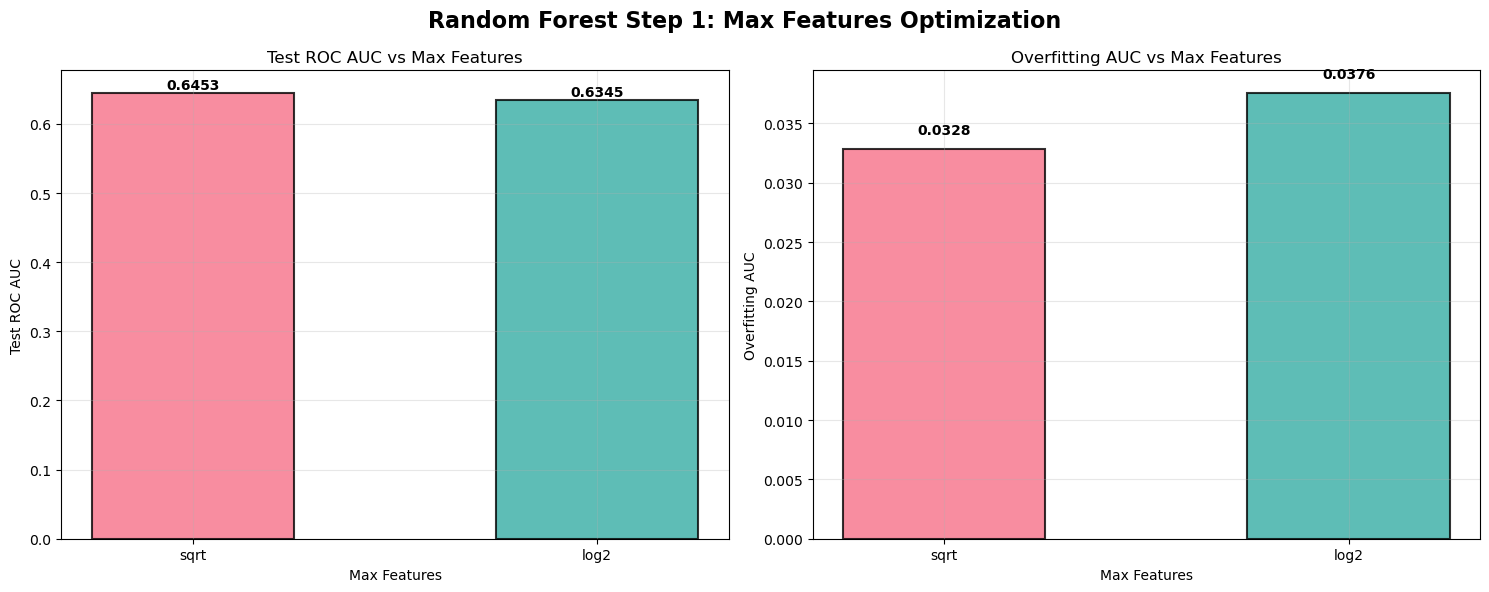


🏆 BEST MAX FEATURES CONFIGURATION (Step 1):
Best Max Features: sqrt
Test ROC AUC: 0.6453
Overfitting AUC: 0.0328

📊 MAX FEATURES OPTIMIZATION SUMMARY:
   Best Test AUC: 0.6453
   Worst Test AUC: 0.6345
   Mean Test AUC: 0.6399
   Std Test AUC: 0.0054


In [67]:
# Create visualization plots for Random Forest Step 1 (max_features optimization)
print("\n📊 Creating Random Forest Step 1 visualization plots...")
print("=" * 60)

# Prepare data for plotting
features_vals = list(rf_features_results.keys())
features_aucs = [rf_features_results[feat]['test_roc_auc'] for feat in features_vals]
features_overfitting = [rf_features_results[feat]['overfitting_auc'] for feat in features_vals]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Random Forest Step 1: Max Features Optimization', fontsize=16, fontweight='bold')

# Plot 1: ROC AUC vs max_features
ax1 = axes[0]
x_pos = range(len(features_vals))
colors = sns.color_palette("husl", len(features_vals))
ax1.bar(x_pos, features_aucs, width=0.5, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Max Features')
ax1.set_ylabel('Test ROC AUC')
ax1.set_title('Test ROC AUC vs Max Features')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(features_vals)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(auto=True)

# Add value labels on bars
for i, v in enumerate(features_aucs):
    ax1.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Overfitting AUC vs max_features
ax2 = axes[1]
ax2.bar(x_pos, features_overfitting, width=0.5, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Max Features')
ax2.set_ylabel('Overfitting AUC')
ax2.set_title('Overfitting AUC vs Max Features')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(features_vals)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(auto=True)

# Add value labels on bars
for i, v in enumerate(features_overfitting):
    ax2.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Find best max_features configuration
print("\n🏆 BEST MAX FEATURES CONFIGURATION (Step 1):")
print("=" * 60)

best_features = max(rf_features_results.keys(), key=lambda x: rf_features_results[x]['test_roc_auc'])
best_features_auc = rf_features_results[best_features]['test_roc_auc']
best_features_overfitting = rf_features_results[best_features]['overfitting_auc']

print(f"Best Max Features: {best_features}")
print(f"Test ROC AUC: {best_features_auc:.4f}")
print(f"Overfitting AUC: {best_features_overfitting:.4f}")

# Summary statistics
print(f"\n📊 MAX FEATURES OPTIMIZATION SUMMARY:")
print(f"   Best Test AUC: {max(features_aucs):.4f}")
print(f"   Worst Test AUC: {min(features_aucs):.4f}")
print(f"   Mean Test AUC: {np.mean(features_aucs):.4f}")
print(f"   Std Test AUC: {np.std(features_aucs):.4f}")


In [ ]:
# Random Forest Fine-tuning - Step 2: Test deeper trees
print("\n🌲 Step 2: Testing Random Forest with deeper trees...")
print("=" * 60)

# Use best max_features from Step 1
print(f"Using best max_features = {best_features} from Step 1")

# Test deeper trees: 6 and 7 (combine with existing depth=5 from Step 1)
deeper_depth_values = [6, 7, 8, 9]
rf_depth_results = {}

# Add the existing depth=5 result to our depth results
rf_depth_results[5] = rf_features_results[best_features].copy()

for max_depth in deeper_depth_values:
    print(f"\n🔍 Testing max_depth = {max_depth}...")
    
    # Evaluate with cross-validation
    results = cv_evaluate_model(
        lambda: RandomForestClassifier(
            n_estimators=100,  # Fixed for depth testing
            max_depth=max_depth,
            min_samples_leaf=rf_min_samples_leaf,
            min_samples_split=rf_min_samples_split,
            max_features=best_features,  # Use best from Step 1
            class_weight='balanced',
            random_state=seed,
            n_jobs=-1
        ),
        train_X_folds, train_y_folds, test_X_folds, test_y_folds, 
        get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
    )
    
    # Store results
    rf_depth_results[max_depth] = {
        'test_roc_auc': results['test_roc_auc'][0],
        'train_roc_auc': results['train_roc_auc'][0],
        'overfitting_auc': results['train_roc_auc'][0] - results['test_roc_auc'][0]
    }
    
    print(f"   Test ROC AUC: {results['test_roc_auc'][0]:.4f}")
    print(f"   Train ROC AUC: {results['train_roc_auc'][0]:.4f}")
    print(f"   Overfitting AUC: {results['train_roc_auc'][0] - results['test_roc_auc'][0]:.4f}")

print(f"\n✅ Step 2 completed! Tested {len(rf_depth_results)} depth configurations (including depth=5 from Step 1).")



🌲 Step 2: Testing Random Forest with deeper trees...
Using best max_features = sqrt from Step 1

🔍 Testing max_depth = 6...
Trained fold 0 in 6.33s
Trained fold 1 in 5.97s
Trained fold 2 in 6.25s
Trained fold 3 in 6.24s
Trained fold 4 in 6.56s
   Test ROC AUC: 0.6486
   Train ROC AUC: 0.6935
   Overfitting AUC: 0.0448

🔍 Testing max_depth = 7...
Trained fold 0 in 6.38s
Trained fold 1 in 6.95s
Trained fold 2 in 7.72s
Trained fold 3 in 7.69s
Trained fold 4 in 7.55s
   Test ROC AUC: 0.6504
   Train ROC AUC: 0.7105
   Overfitting AUC: 0.0601

🔍 Testing max_depth = 8...
Trained fold 0 in 7.79s
Trained fold 1 in 8.41s
Trained fold 2 in 7.64s
Trained fold 3 in 6.67s
Trained fold 4 in 6.67s
   Test ROC AUC: 0.6508
   Train ROC AUC: 0.7263
   Overfitting AUC: 0.0755

🔍 Testing max_depth = 9...
Trained fold 0 in 7.66s
Trained fold 1 in 8.25s
Trained fold 2 in 7.05s
Trained fold 3 in 7.74s
Trained fold 4 in 15.57s
   Test ROC AUC: 0.6513
   Train ROC AUC: 0.7433
   Overfitting AUC: 0.0920

✅ Ste


📊 Creating Random Forest Step 2 visualization plots...


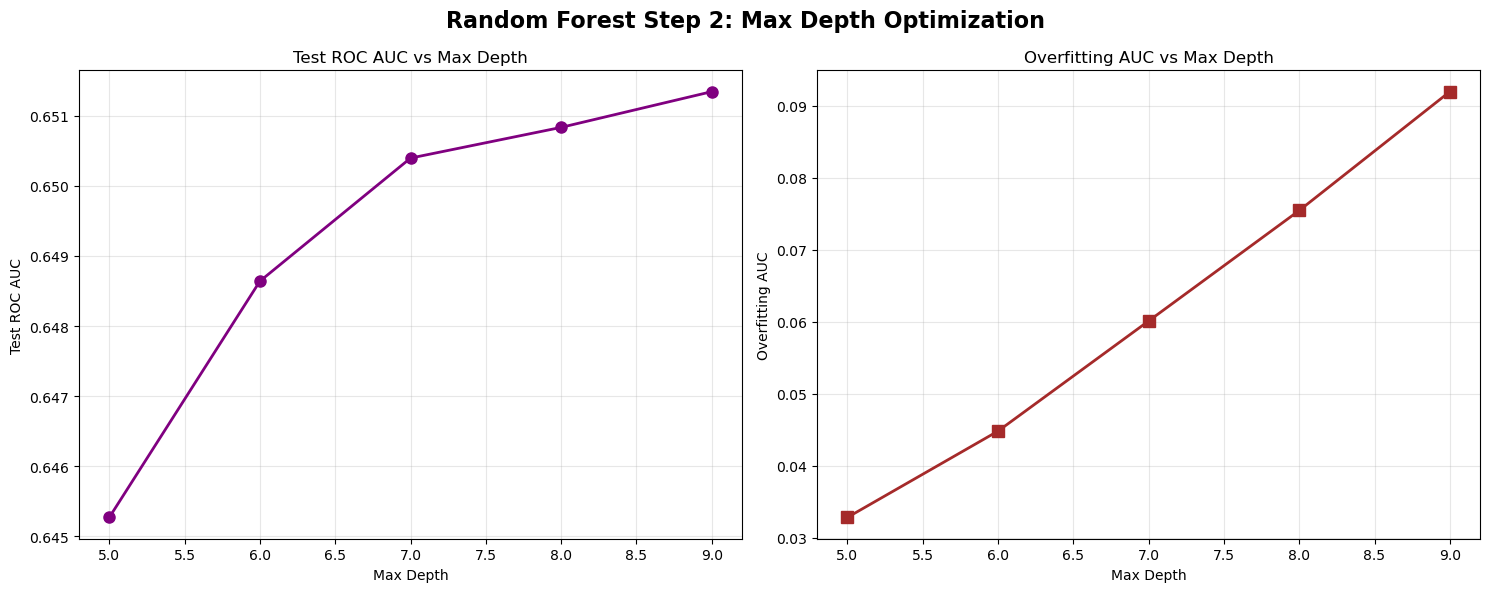


🏆 BEST MAX DEPTH CONFIGURATION (Step 2):
Best Max Depth: 9
Test ROC AUC: 0.6513
Overfitting AUC: 0.0920

📊 MAX DEPTH OPTIMIZATION SUMMARY:
   Best Test AUC: 0.6513
   Worst Test AUC: 0.6453
   Mean Test AUC: 0.6493
   Std Test AUC: 0.0022


In [69]:
# Create visualization plots for Random Forest Step 2 (depth optimization)
print("\n📊 Creating Random Forest Step 2 visualization plots...")
print("=" * 60)

# Prepare data for plotting
depth_vals = list(rf_depth_results.keys())
depth_aucs = [rf_depth_results[depth]['test_roc_auc'] for depth in depth_vals]
depth_overfitting = [rf_depth_results[depth]['overfitting_auc'] for depth in depth_vals]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Random Forest Step 2: Max Depth Optimization', fontsize=16, fontweight='bold')

# Plot 1: ROC AUC vs max_depth
ax1 = axes[0]
ax1.plot(depth_vals, depth_aucs, 'o-', linewidth=2, markersize=8, color='purple')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('Test ROC AUC')
ax1.set_title('Test ROC AUC vs Max Depth')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(auto=True)

# Plot 2: Overfitting AUC vs max_depth
ax2 = axes[1]
ax2.plot(depth_vals, depth_overfitting, 's-', linewidth=2, markersize=8, color='brown')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Overfitting AUC')
ax2.set_title('Overfitting AUC vs Max Depth')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(auto=True)

plt.tight_layout()
plt.show()

# Find best depth configuration
print("\n🏆 BEST MAX DEPTH CONFIGURATION (Step 2):")
print("=" * 60)

best_rf_depth = max(rf_depth_results.keys(), key=lambda x: rf_depth_results[x]['test_roc_auc'])
best_rf_depth_auc = rf_depth_results[best_rf_depth]['test_roc_auc']
best_rf_depth_overfitting = rf_depth_results[best_rf_depth]['overfitting_auc']

print(f"Best Max Depth: {best_rf_depth}")
print(f"Test ROC AUC: {best_rf_depth_auc:.4f}")
print(f"Overfitting AUC: {best_rf_depth_overfitting:.4f}")

# Summary statistics
print(f"\n📊 MAX DEPTH OPTIMIZATION SUMMARY:")
print(f"   Best Test AUC: {max(depth_aucs):.4f}")
print(f"   Worst Test AUC: {min(depth_aucs):.4f}")
print(f"   Mean Test AUC: {np.mean(depth_aucs):.4f}")
print(f"   Std Test AUC: {np.std(depth_aucs):.4f}")


In [ ]:
# Random Forest Fine-tuning - Step 3: Optimize n_estimators
print("\n🌲 Step 3: Testing Random Forest with different n_estimators...")
print("=" * 60)

# Use best max_features from Step 1 and best depth from Step 2
print(f"Using best max_features = {best_features} from Step 1")
print(f"Using best max_depth = {best_rf_depth} from Step 2")

# Test n_estimators: 100, 200, 400
n_estimators_values = [100, 200, 400]
rf_estimators_results = {}

for n_estimators in n_estimators_values:
    print(f"\n🔍 Testing n_estimators = {n_estimators}...")
    
    # Create Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=rf_max_depth,
        min_samples_leaf=rf_min_samples_leaf,
        min_samples_split=rf_min_samples_split,
        max_features=best_features,  # Use best from Step 1
        random_state=seed,
        n_jobs=-1
    )
    
    # Evaluate with cross-validation
    results = cv_evaluate_model(
        lambda: RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=best_rf_depth,  # Use best from Step 2
            min_samples_leaf=rf_min_samples_leaf,
            min_samples_split=rf_min_samples_split,
            max_features=best_features,  # Use best from Step 1
            class_weight='balanced',
            random_state=seed,
            n_jobs=-1
        ),
        train_X_folds, train_y_folds, test_X_folds, test_y_folds, 
        get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
    )
    
    # Store results
    rf_estimators_results[n_estimators] = {
        'test_roc_auc': results['test_roc_auc'][0],
        'train_roc_auc': results['train_roc_auc'][0],
        'overfitting_auc': results['train_roc_auc'][0] - results['test_roc_auc'][0]
    }
    
    print(f"   Test ROC AUC: {results['test_roc_auc'][0]:.4f}")
    print(f"   Train ROC AUC: {results['train_roc_auc'][0]:.4f}")
    print(f"   Overfitting AUC: {results['train_roc_auc'][0] - results['test_roc_auc'][0]:.4f}")

print(f"\n✅ Step 3 completed! Tested {len(n_estimators_values)} n_estimators configurations.")



🌲 Step 3: Testing Random Forest with different n_estimators...
Using best max_features = sqrt from Step 1
Using best max_depth = 9 from Step 2

🔍 Testing n_estimators = 100...
Trained fold 0 in 12.49s
Trained fold 1 in 14.36s
Trained fold 2 in 18.97s
Trained fold 3 in 22.83s
Trained fold 4 in 16.51s
   Test ROC AUC: 0.6513
   Train ROC AUC: 0.7433
   Overfitting AUC: 0.0920

🔍 Testing n_estimators = 200...
Trained fold 0 in 29.93s
Trained fold 1 in 28.47s
Trained fold 2 in 26.91s
Trained fold 3 in 15.49s
Trained fold 4 in 16.72s
   Test ROC AUC: 0.6530
   Train ROC AUC: 0.7456
   Overfitting AUC: 0.0926

🔍 Testing n_estimators = 400...
Trained fold 0 in 30.01s
Trained fold 1 in 31.29s
Trained fold 2 in 30.60s
Trained fold 3 in 27.07s
Trained fold 4 in 28.76s
   Test ROC AUC: 0.6543
   Train ROC AUC: 0.7464
   Overfitting AUC: 0.0921

✅ Step 3 completed! Tested 3 n_estimators configurations.



📊 Creating Random Forest Step 3 visualization plots...


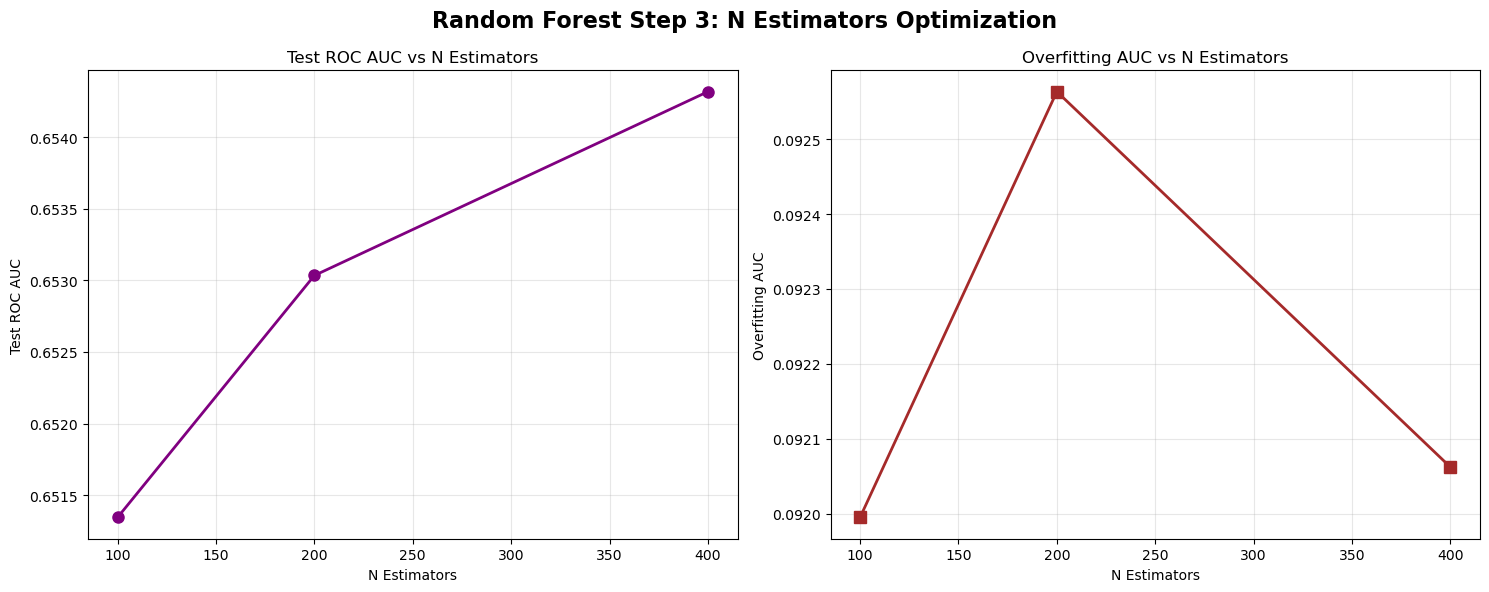


🏆 BEST N ESTIMATORS CONFIGURATION (Step 3):

🏆 OVERALL BEST RANDOM FOREST CONFIGURATION:
   Best Max Features: sqrt
   Best N Estimators: 400
   Max Depth: 5
   Min Samples Leaf: 100
   Min Samples Split: 200
   Test ROC AUC: 0.6543
   Overfitting AUC: 0.0921

📊 N ESTIMATORS OPTIMIZATION SUMMARY:
   Best Test AUC: 0.6543
   Worst Test AUC: 0.6513
   Mean Test AUC: 0.6529
   Std Test AUC: 0.0012


In [71]:
# Create visualization plots for Random Forest Step 3 (n_estimators optimization)
print("\n📊 Creating Random Forest Step 3 visualization plots...")
print("=" * 60)

# Prepare data for plotting
estimators_vals = list(rf_estimators_results.keys())
estimators_aucs = [rf_estimators_results[est]['test_roc_auc'] for est in estimators_vals]
estimators_overfitting = [rf_estimators_results[est]['overfitting_auc'] for est in estimators_vals]

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Random Forest Step 3: N Estimators Optimization', fontsize=16, fontweight='bold')

# Plot 1: ROC AUC vs n_estimators
ax1 = axes[0]
ax1.plot(estimators_vals, estimators_aucs, 'o-', linewidth=2, markersize=8, color='purple')
ax1.set_xlabel('N Estimators')
ax1.set_ylabel('Test ROC AUC')
ax1.set_title('Test ROC AUC vs N Estimators')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(auto=True)

# Plot 2: Overfitting AUC vs n_estimators
ax2 = axes[1]
ax2.plot(estimators_vals, estimators_overfitting, 's-', linewidth=2, markersize=8, color='brown')
ax2.set_xlabel('N Estimators')
ax2.set_ylabel('Overfitting AUC')
ax2.set_title('Overfitting AUC vs N Estimators')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(auto=True)

plt.tight_layout()
plt.show()

# Find best n_estimators configuration
print("\n🏆 BEST N ESTIMATORS CONFIGURATION (Step 3):")
print("=" * 60)

best_estimators = max(rf_estimators_results.keys(), key=lambda x: rf_estimators_results[x]['test_roc_auc'])
best_estimators_auc = rf_estimators_results[best_estimators]['test_roc_auc']
best_estimators_overfitting = rf_estimators_results[best_estimators]['overfitting_auc']

# Overall best configuration
print(f"\n🏆 OVERALL BEST RANDOM FOREST CONFIGURATION:")
print(f"   Best Max Features: {best_features}")
print(f"   Best N Estimators: {best_estimators}")
print(f"   Max Depth: {rf_max_depth}")
print(f"   Min Samples Leaf: {rf_min_samples_leaf}")
print(f"   Min Samples Split: {rf_min_samples_split}")
print(f"   Test ROC AUC: {best_estimators_auc:.4f}")
print(f"   Overfitting AUC: {best_estimators_overfitting:.4f}")

# Summary statistics
print(f"\n📊 N ESTIMATORS OPTIMIZATION SUMMARY:")
print(f"   Best Test AUC: {max(estimators_aucs):.4f}")
print(f"   Worst Test AUC: {min(estimators_aucs):.4f}")
print(f"   Mean Test AUC: {np.mean(estimators_aucs):.4f}")
print(f"   Std Test AUC: {np.std(estimators_aucs):.4f}")


**NOTE**

For the Random Forest model, we began with the maximum tree depth and minimum leaf size obtained from the fine-tuned decision tree. We first compared the sqrt and log2 settings for the maximum number of features, finding sqrt to yield better performance. Next, we examined the effect of increasing tree depth, as the bagging and feature-constrained nature of Random Forests typically allows for deeper trees. Although AUROC continued to improve with increasing depth, we stopped at a depth of 9, beyond which the overfitting metric rose sharply. Finally, we tested different numbers of estimators and found that while increasing the estimator count slightly improved AUROC, the gain was marginal; thus, an appropriate number was selected to keep training time manageable.

### XGBoost: Fine-tuning Max Depth & Subsample

In [ ]:
# XGBoost Fine-tuning - Full Grid Search
print("\n🚀 Testing XGBoost with full grid search...")
print("=" * 60)

# Define parameter grid
max_depth_values = [3, 4, 5, 6]
subsample_values = [0.5, 0.8, 1.0]
xgb_grid_results = {}

total_combinations = len(max_depth_values) * len(subsample_values)
print(f"Testing {total_combinations} combinations: {max_depth_values} depths × {subsample_values} subsamples")

combination_count = 0
for max_depth in max_depth_values:
    for subsample in subsample_values:
        combination_count += 1
        print(f"\n🔍 Testing combination {combination_count}/{total_combinations}: max_depth={max_depth}, subsample={subsample}...")
        
        # Evaluate with cross-validation
        results = cv_evaluate_model(
            lambda: xgb.XGBClassifier(
                max_depth=max_depth,
                subsample=subsample,
                colsample_bytree=subsample,  # Apply same subsample value to colsample_bytree
                n_estimators=100,
                learning_rate=0.1,
                scale_pos_weight=len(train_y_folds[0][train_y_folds[0]==0])/len(train_y_folds[0][train_y_folds[0]==1]),  # Handle class imbalance
                random_state=seed,
                n_jobs=-1
            ),
            train_X_folds, train_y_folds, test_X_folds, test_y_folds, 
            get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
        )
        
        # Store results
        xgb_grid_results[(max_depth, subsample)] = {
            'test_roc_auc': results['test_roc_auc'][0],
            'train_roc_auc': results['train_roc_auc'][0],
            'overfitting_auc': results['train_roc_auc'][0] - results['test_roc_auc'][0]
        }
        
        print(f"   Test ROC AUC: {results['test_roc_auc'][0]:.4f}")
        print(f"   Train ROC AUC: {results['train_roc_auc'][0]:.4f}")
        print(f"   Overfitting AUC: {results['train_roc_auc'][0] - results['test_roc_auc'][0]:.4f}")

print(f"\n✅ Grid search completed! Tested {total_combinations} combinations.")



🚀 Testing XGBoost with full grid search...
Testing 12 combinations: [3, 4, 5, 6] depths × [0.5, 0.8, 1.0] subsamples

🔍 Testing combination 1/12: max_depth=3, subsample=0.5...
Trained fold 0 in 1.88s
Trained fold 1 in 1.68s
Trained fold 2 in 1.71s
Trained fold 3 in 1.82s
Trained fold 4 in 2.15s
   Test ROC AUC: 0.6720
   Train ROC AUC: 0.7041
   Overfitting AUC: 0.0321

🔍 Testing combination 2/12: max_depth=3, subsample=0.8...
Trained fold 0 in 1.66s
Trained fold 1 in 1.62s
Trained fold 2 in 1.62s
Trained fold 3 in 1.62s
Trained fold 4 in 1.84s
   Test ROC AUC: 0.6753
   Train ROC AUC: 0.7047
   Overfitting AUC: 0.0293

🔍 Testing combination 3/12: max_depth=3, subsample=1.0...
Trained fold 0 in 1.59s
Trained fold 1 in 1.53s
Trained fold 2 in 1.53s
Trained fold 3 in 1.69s
Trained fold 4 in 1.67s
   Test ROC AUC: 0.6750
   Train ROC AUC: 0.7015
   Overfitting AUC: 0.0265

🔍 Testing combination 4/12: max_depth=4, subsample=0.5...
Trained fold 0 in 1.97s
Trained fold 1 in 1.85s
Trained fo


📊 Creating XGBoost grid search visualization plot...


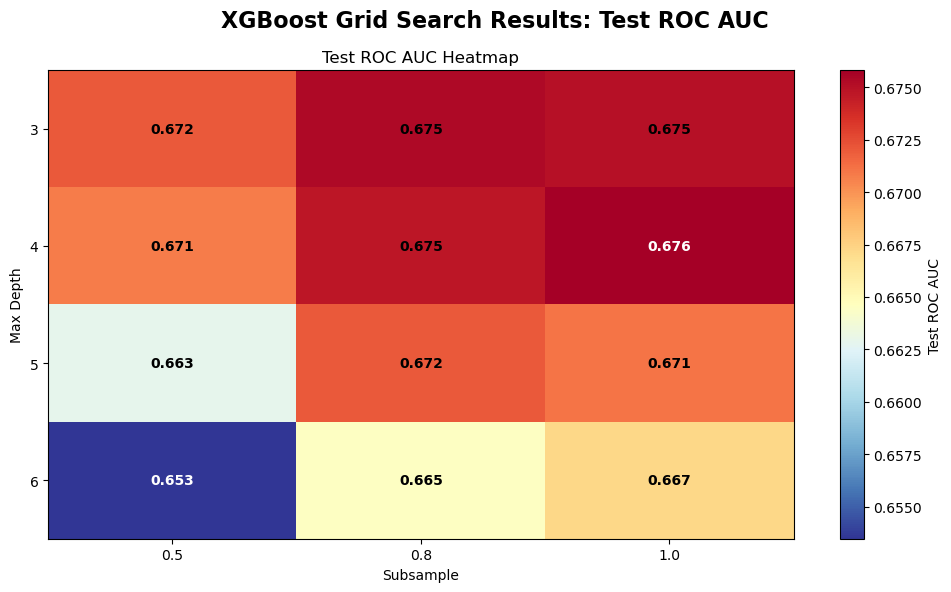


🏆 BEST XGBOOST CONFIGURATION:
Best Max Depth: 4
Best Subsample: 1.0
Test ROC AUC: 0.6758
Overfitting AUC: 0.0530

📊 GRID SEARCH SUMMARY:
   Best Test AUC: 0.6758
   Worst Test AUC: 0.6535
   Mean Test AUC: 0.6696
   Std Test AUC: 0.0063

🔄 COMPARISON WITH BASELINE (max_depth=5, subsample=1.0):
   Baseline Test AUC: 0.6710
   Best Test AUC: 0.6758
   Improvement: 0.0048
   🎉 Grid search improved performance!


In [64]:
# Create visualization plot for XGBoost Grid Search (ROC AUC only)
print("\n📊 Creating XGBoost grid search visualization plot...")
print("=" * 60)

# Prepare data for heatmap (ROC AUC only)
heatmap_auc = np.zeros((len(max_depth_values), len(subsample_values)))

for i, max_depth in enumerate(max_depth_values):
    for j, subsample in enumerate(subsample_values):
        heatmap_auc[i, j] = xgb_grid_results[(max_depth, subsample)]['test_roc_auc']

# Create heatmap plot (ROC AUC only)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('XGBoost Grid Search Results: Test ROC AUC', fontsize=16, fontweight='bold')

# Plot: Test ROC AUC Heatmap
im = ax.imshow(heatmap_auc, cmap='RdYlBu_r', aspect='auto')
ax.set_xticks(range(len(subsample_values)))
ax.set_yticks(range(len(max_depth_values)))
ax.set_xticklabels([f'{s}' for s in subsample_values])
ax.set_yticklabels([f'{d}' for d in max_depth_values])
ax.set_xlabel('Subsample')
ax.set_ylabel('Max Depth')
ax.set_title('Test ROC AUC Heatmap')

# Add text annotations with conditional color
max_val = np.max(heatmap_auc)
min_val = np.min(heatmap_auc)
for i in range(len(max_depth_values)):
    for j in range(len(subsample_values)):
        val = heatmap_auc[i, j]
        text_color = "white" if (val == max_val or val == min_val) else "black"
        ax.text(j, i, f'{val:.3f}', ha="center", va="center", color=text_color, fontweight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Test ROC AUC')

plt.tight_layout()
plt.show()

# Find best configuration
print("\n🏆 BEST XGBOOST CONFIGURATION:")
print("=" * 60)

best_params = max(xgb_grid_results.keys(), key=lambda x: xgb_grid_results[x]['test_roc_auc'])
best_auc = xgb_grid_results[best_params]['test_roc_auc']
best_overfitting = xgb_grid_results[best_params]['overfitting_auc']

print(f"Best Max Depth: {best_params[0]}")
print(f"Best Subsample: {best_params[1]}")
print(f"Test ROC AUC: {best_auc:.4f}")
print(f"Overfitting AUC: {best_overfitting:.4f}")

# Summary statistics
print(f"\n📊 GRID SEARCH SUMMARY:")
print(f"   Best Test AUC: {max([xgb_grid_results[params]['test_roc_auc'] for params in xgb_grid_results]):.4f}")
print(f"   Worst Test AUC: {min([xgb_grid_results[params]['test_roc_auc'] for params in xgb_grid_results]):.4f}")
print(f"   Mean Test AUC: {np.mean([xgb_grid_results[params]['test_roc_auc'] for params in xgb_grid_results]):.4f}")
print(f"   Std Test AUC: {np.std([xgb_grid_results[params]['test_roc_auc'] for params in xgb_grid_results]):.4f}")

# Compare with baseline (depth=5, subsample=1.0)
baseline_params = (5, 1.0)
if baseline_params in xgb_grid_results:
    baseline_auc = xgb_grid_results[baseline_params]['test_roc_auc']
    print(f"\n🔄 COMPARISON WITH BASELINE (max_depth={baseline_params[0]}, subsample={baseline_params[1]}):")
    print(f"   Baseline Test AUC: {baseline_auc:.4f}")
    print(f"   Best Test AUC: {best_auc:.4f}")
    print(f"   Improvement: {best_auc - baseline_auc:.4f}")
    
    if best_auc > baseline_auc:
        print(f"   🎉 Grid search improved performance!")
    else:
        print(f"   📊 Baseline was already optimal")


**NOTE**

For the XGBoost model, we tested smaller trees compared to the fine-tuned decision tree. This differs from the Random Forest approach because XGBoost builds trees sequentially, with each tree correcting the errors of the previous ones, making shallower trees more appropriate. We concurrently tested different subsampling proportions (0.5, 0.8, and 1.0). Since the number of parameter combinations was small, a simple grid search was used. The optimal configuration was found to be a tree depth of 4 with no subsampling.